# Tutorial 2: A Deeper Dive into the Sea Level Equation

In the first tutorial, we calculated and plotted a basic sea-level fingerprint. Now, we'll explore the problem in more detail.

This tutorial will cover four key topics:
1.  **Defining Custom Loads:** Instead of using a helper for a whole hemisphere, we will create a more localized load, simulating the melt of a specific ice cap.
2.  **Visualizing All Physical Outputs:** We will investigate all the physical fields returned by the solver: sea-level change, solid Earth displacement, and the different components of the gravity field.
3.  **Exploring Solver Options:** We will examine the effect of **rotational feedbacks** (polar wander) on the sea-level solution.
4.  **Advanced Initialization:** We will briefly discuss some of the optional parameters for the `FingerPrint` class, including how to use custom non-dimensionalization schemes.

## Setup and Initialization

As before, we start by importing the necessary libraries and initializing our `FingerPrint` model with a present-day background state. This workflow will be the standard starting point for most forward-modeling problems.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyslfp as sl

# 1. Initialise the fingerprint model
fp = sl.FingerPrint(lmax=256)

# 2. Set the background state to the present day
fp.set_state_from_ice_ng(version=sl.IceModel.ICE7G, date=0.0)

## Step 1: Creating a Custom Surface Load

While helpers like `northern_hemisphere_load` are useful, we often want to model more specific scenarios. Let's simulate the melt of a simplified, circular ice sheet over southern Greenland.

It's important to note that all spatial fields in `pyslfp` (including loads, ice thickness, and the final results) are standard `pyshtools.SHGrid` objects. This means that while the library provides convenient helper functions like `disk_load`, you have the full power of the `pyshtools` library at your disposal. You can create `SHGrid` objects directly from NumPy arrays, spherical harmonic coefficients, or by loading external files, giving you complete flexibility to define any custom load you need.

For this example, we'll first create a `SHGrid` object representing the *change in ice thickness* using the `disk_load` helper. We'll simulate a 100-meter thinning over a 5-degree radius disk centered on Greenland. We then use `direct_load_from_ice_thickness_change` to convert this into a physically correct surface mass load.

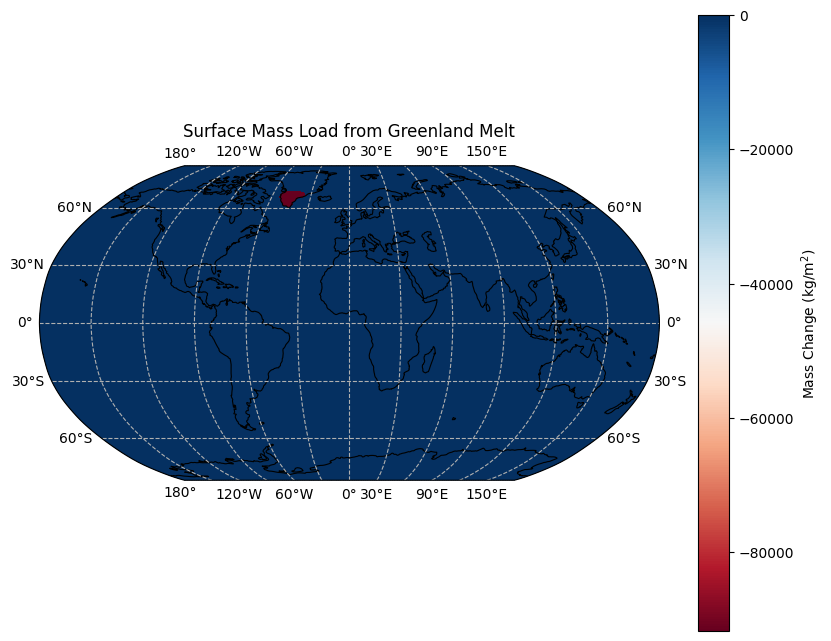

In [2]:
# Define the parameters for a disk load over Southern Greenland
lat_greenland, lon_greenland = 65.0, -45.0
radius_deg = 5.0
thickness_change_meters = -100.0

# Create a grid representing the change in ice thickness
ice_thickness_change = fp.disk_load(
    delta=radius_deg,
    latitude=lat_greenland,
    longitude=lon_greenland,
    amplitude=thickness_change_meters,
)

# Convert the ice thickness change into a surface mass load (in kg/m^2)
direct_load = fp.direct_load_from_ice_thickness_change(ice_thickness_change)

# Optional: Plot the load to see what it looks like
fig, ax, im = sl.plot(direct_load, coasts=True)
ax.set_title("Surface Mass Load from Greenland Melt")
fig.colorbar(im, ax=ax, label="Mass Change (kg/m$^2$)")
plt.show()

## Step 2: Solving for All Output Fields

Now we run the solver, but this time we will capture all four of the output fields in separate variables. We will also print the change in angular velocity, which is returned as a simple NumPy array `[ω_x, ω_y]` representing the change in the x and y components of the Earth's rotation vector. The z-component of the angular velocity change is smaller by around two-orders of magnitude and is neglected in the modelling. 

In [3]:
sea_level_change, displacement, gravity_potential_change, angular_velocity_change = fp(
    direct_load=direct_load
)

print(f"Change in angular velocity vector [ω_x, ω_y]: {angular_velocity_change}")

Change in angular velocity vector [ω_x, ω_y]: [ 2.17592486e-10 -1.85351577e-10]


## Step 3: Visualizing the Physical Fields

With all the results in hand, we can now plot them to understand the full physical response to the ice melt.

### Sea Level Change

First, we plot the sea-level fingerprint for our new Greenland load. As a reminder, this field represents the change in the sea surface equipotential (the geoid). We will again apply an ocean mask to focus the visualization on the world's oceans, but the underlying field is well-defined everywhere.

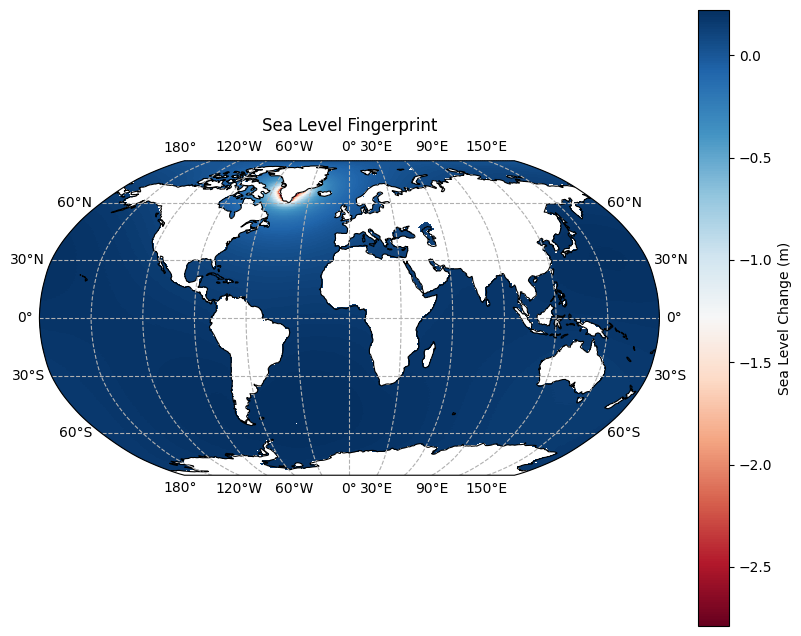

In [4]:
fig, ax, im = sl.plot(
    sea_level_change * fp.ocean_projection(),
    coasts=True,    
)
ax.set_title("Sea Level Fingerprint")
fig.colorbar(im, ax=ax, label="Sea Level Change (m)")
plt.show()

### Vertical Displacement

Next, we visualize the `displacement` field. This represents the **elastic deformation of the solid Earth**.

You should see a positive signal (uplift or "rebound") centered on the location where the ice was removed, as the crust is no longer weighed down. This uplift is surrounded by a weaker negative signal (subsidence), often called the "peripheral bulge." This deformation occurs on both land and the sea floor.

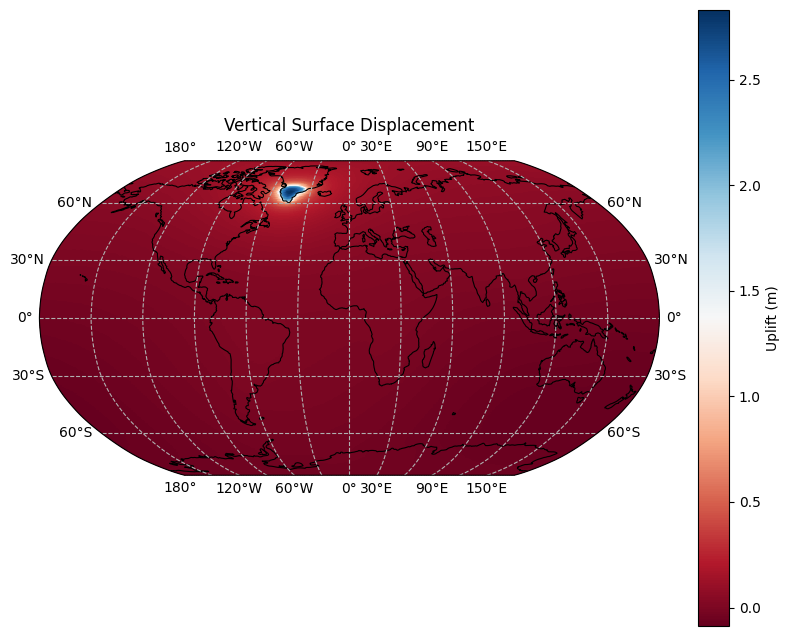

In [5]:
fig, ax, im = sl.plot(
    displacement,
    coasts=True,    
)
ax.set_title("Vertical Surface Displacement")
fig.colorbar(im, ax=ax, label="Uplift (m)")
plt.show()

### Gravity and Gravitational Potential Change

It is important to distinguish between two related quantities:
* **Gravity Potential:** The potential experienced by an observer on the rotating Earth's surface. It includes the true **gravitational potential** (from mass) and the **centrifugal potential** (from rotation).
* **Gravitational Potential:** The potential due to mass alone. This is what a non-rotating observer or an orbiting satellite like GRACE would measure.

The `fp()` solver returns the total **`gravity_potential_change`**. For many applications, we want to isolate the pure **`gravitational_potential_change`**. The library provides a convenience method to perform this conversion, which subtracts the centrifugal potential component.

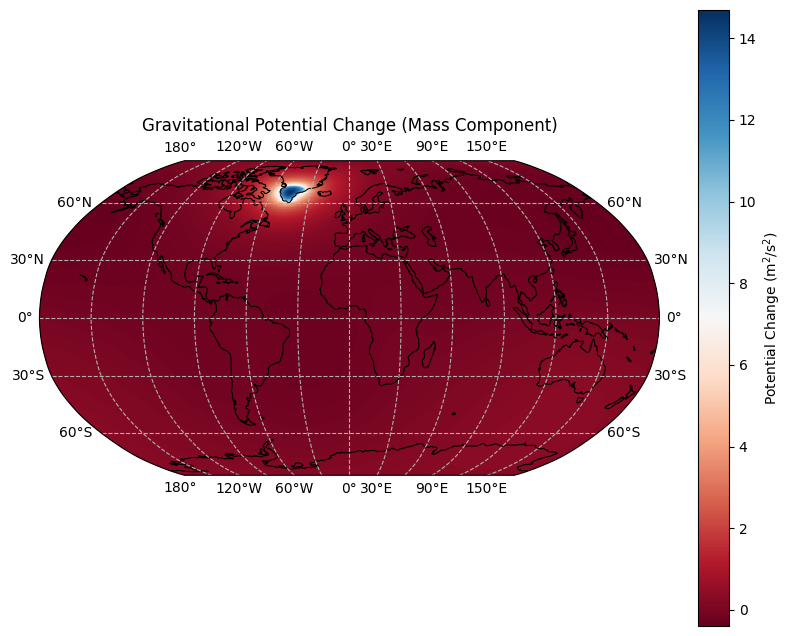

In [6]:
# Convert the total gravity potential change to pure gravitational potential change
gravitational_potential_change = fp.gravity_potential_change_to_gravitational_potential_change(
    gravity_potential_change, angular_velocity_change
)

# Plot the result
fig, ax, im = sl.plot(
    gravitational_potential_change,
    coasts=True,    
)
ax.set_title("Gravitational Potential Change (Mass Component)")
fig.colorbar(im, ax=ax, label="Potential Change (m$^2$/s$^2$)")
plt.show()

The sea level change is a sum of contributions from:
- verical displacement
- changes to the gravity potential
- a uniform change required to conserve mass between the ice sheets and the oceans. 
- 
Mathematically, we can write the sea level change as:
$$
\Delta SL = -\frac{1}{g}(\nabla \Phi \cdot \mathbf{u} + \phi + \psi) + \frac{\Delta\Phi_{g}}{g},
$$
where $g$ is the acceleration due to gravity at the surface, $\Phi$ the the background gravitational potential, $\mathbf{u}$
is the displacement vector, $\phi$ is the perturbation to the gravitational potential, $\psi$ the perturbation to the 
centrifugal potential, and $\Delta \Phi_{g}$ is a constant change in the value of the centrifugal potential on the equipotential
that defined the mean set surface. 

Below we can subtract the changes associated with vertical displacement and gravity potential from the sea level change to revel the uniform component. The value for this uniform change can also be calculated directly and simply using the `mean_sea_level_change` method for the  `FingerPrint` class.

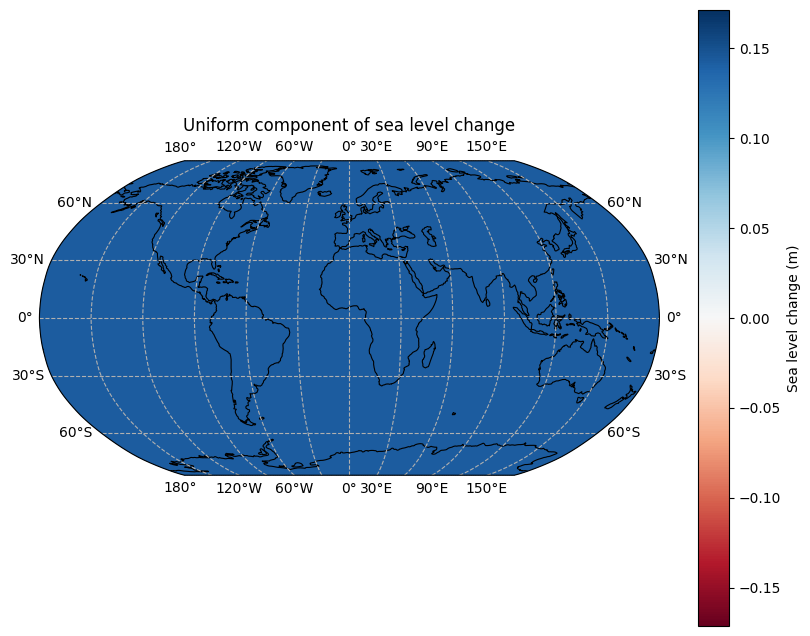

Mean sea level change = 0.15621858886277087 m


In [7]:
uniform_sea_level_change = sea_level_change + displacement + gravity_potential_change / fp.gravitational_acceleration

# Plot the result
fig, ax, im = sl.plot(
    uniform_sea_level_change,
    coasts=True,    
    symmetric=True
)
ax.set_title("Uniform component of sea level change")
fig.colorbar(im, ax=ax, label="Sea level change (m)")
plt.show()

mean_sea_level_change = fp.mean_sea_level_change(direct_load)
print(f'Mean sea level change = {mean_sea_level_change} m')

## Step 4: Investigating Rotational Feedbacks

The `pyslfp` solver includes the effect of **rotational feedbacks** by default. When a large mass is redistributed on the Earth's surface, it changes the planet's tensor of inertia, causing the rotation axis to shift slightly relative to the crust. This "polar wander" induces its own distinct, long-wavelength pattern of sea-level change.

We can investigate the importance of this effect by running the solver again with the `rotational_feedbacks` flag set to `False`. We can then subtract this new result from our original result to isolate the pure rotational signal.

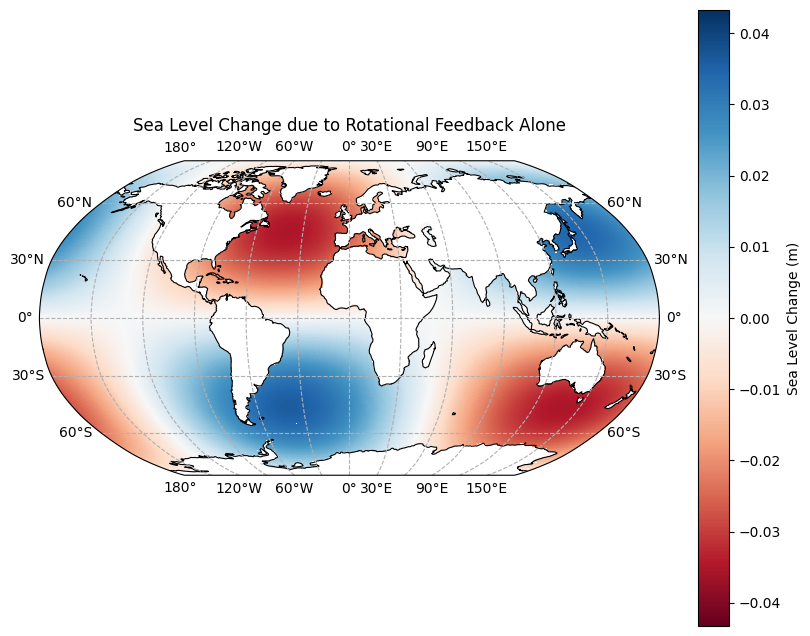

In [8]:
# Solve the sea level equation again, but with rotational feedbacks turned OFF
sea_level_no_rotation, _, _, _ = fp(
    direct_load=direct_load,
    rotational_feedbacks=False
)

# Calculate the difference to isolate the rotational effect
rotation_effect = sea_level_change - sea_level_no_rotation

# Plot the isolated rotational signal
fig, ax, im = sl.plot(
    rotation_effect * fp.ocean_projection(),
    coasts=True,    
    symmetric=True
)
ax.set_title("Sea Level Change due to Rotational Feedback Alone")
fig.colorbar(im, ax=ax, label="Sea Level Change (m)")
plt.show()

## Advanced Topic: FingerPrint Initialization Options

The `FingerPrint` class can be customized at initialization. The main arguments are:
* `lmax`: Sets the spherical harmonic resolution.
* `grid`: Sets the `pyshtools` grid type (e.g., `'DH'`, `'GLQ'`, or `'DH2'` for double longitudinal sampling).
* `love_number_file`: Path to a custom Love number file for a different Earth model.
* `earth_model_parameters`: A custom `EarthModelParameters` object to control physical constants and the non-dimensionalization scheme.

### Non-Dimensionalisation Schemes
Internally, the library solves the equations using non-dimensional quantities to improve numerical stability. By default, `FingerPrint` uses a **trivial non-dimensionalization scheme** (all scales are 1.0), which is equivalent to working directly in SI units.

**Important Note:** The outputs of the solver are returned in these non-dimensional units. If you use a custom scheme, you must re-scale your results manually for interpretation.

For most geophysical applications, it is better to use a sensible scheme. There are two ways to do this:
1.  **Using the factory method:** The `EarthModelParameters.from_standard_non_dimensionalisation()` method provides a pre-configured scheme based on the Earth's radius, water density, and the hour. This is the easiest approach.
2.  **Using the constructor directly:** To have full control, you can instantiate `EarthModelParameters` directly, providing your own values for `length_scale`, `density_scale`, `time_scale`, and any of the physical constants.

In [9]:
# --- Option 1: Use the convenient factory method ---
print("--- Standard Scheme from Factory Method ---")
standard_params = sl.EarthModelParameters.from_standard_non_dimensionalisation()

# We can inspect the base scales...
print(f"  Base Length Scale: {standard_params.length_scale:.2e} m")
print(f"  Base Density Scale: {standard_params.density_scale:.2e} kg/m^3")
print(f"  Base Time Scale: {standard_params.time_scale:.2e} s")

# ...and also the derived scales.
print(f"  Derived Mass Scale: {standard_params.mass_scale:.2e} kg")
print(f"  Derived Grav. Potential Scale: {standard_params.gravitational_potential_scale:.2e} m^2/s^2")

# ...and see their effect on physical constants.
print(f"  Non-dimensional Earth Mass: {standard_params.mass:.4f}")
print(f"  Non-dimensional Rotation Freq.: {standard_params.rotation_frequency:.4f}")


# --- Option 2: Use the constructor for a fully custom scheme ---
print("\n--- Fully Custom Scheme from Constructor ---")
custom_params = sl.EarthModelParameters(
    length_scale=6.0e6, # Use a round number for length
    density_scale=1028.0, # Use a more precise sea water density
    time_scale=86400.0 # Use one day as the time scale
)
# We can inspect the base scales...
print(f"  Base Length Scale: {custom_params.length_scale:.2e} m")
print(f"  Base Density Scale: {custom_params.density_scale:.2e} kg/m^3")
print(f"  Base Time Scale: {custom_params.time_scale:.2e} s")

# ...and also the derived scales.
print(f"  Derived Mass Scale: {custom_params.mass_scale:.2e} kg")
print(f"  Derived Grav. Potential Scale: {custom_params.gravitational_potential_scale:.2e} m^2/s^2")

# ...and see their effect on physical constants.
print(f"  Non-dimensional Earth Mass: {custom_params.mass:.4f}")
print(f"  Non-dimensional Rotation Freq.: {custom_params.rotation_frequency:.4f}")


# This custom object could then be passed to the FingerPrint constructor:
# fp_custom = sl.FingerPrint(lmax=256, earth_model_parameters=custom_params)
print("\nA FingerPrint model could now be initialized with either of these schemes.")

--- Standard Scheme from Factory Method ---
  Base Length Scale: 6.37e+06 m
  Base Density Scale: 1.00e+03 kg/m^3
  Base Time Scale: 3.60e+03 s
  Derived Mass Scale: 2.59e+23 kg
  Derived Grav. Potential Scale: 3.13e+06 m^2/s^2
  Non-dimensional Earth Mass: 23.1016
  Non-dimensional Rotation Freq.: 0.2618

--- Fully Custom Scheme from Constructor ---
  Base Length Scale: 6.00e+06 m
  Base Density Scale: 1.03e+03 kg/m^3
  Base Time Scale: 8.64e+04 s
  Derived Mass Scale: 2.22e+23 kg
  Derived Grav. Potential Scale: 4.82e+03 m^2/s^2
  Non-dimensional Earth Mass: 26.9041
  Non-dimensional Rotation Freq.: 6.2832

A FingerPrint model could now be initialized with either of these schemes.


## Conclusion

In this tutorial, we went beyond the basics to explore the rich outputs and options of the `pyslfp` library. We learned how to:

* Create a specific, localized surface load to represent a targeted melt scenario.
* Visualize and interpret the full suite of physical responses, including the distinction between gravity and gravitational potential.
* Isolate and understand the physical effect of rotational feedbacks on the final sea-level pattern.
* Customize the model's physical parameters and non-dimensionalization scheme for advanced use cases.